# RSNA Pneumonia Detection Challenge
Team: sciencerulez
- Travis Clarke [[github](https://github.com/tclarke104)]
- Michael Farrell [[github](https://github.com/mmmfarrell)]

# Yolo
This version we will implement a YOLO detector following the step by step walkthrough
- Here's a good walkthough of how to implement it [YOLO ipynb](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)
- Here's the [YOLO Paper](https://arxiv.org/pdf/1506.02640.pdf)
- Here's the [YOLO video](https://www.coursera.org/learn/convolutional-neural-networks/lecture/fF3O0/yolo-algorithm)

I've never used Keras, but it looks cool so I'm gonna try to use it

## Download and import dependencies

In [0]:
# Install dependencies not included by Colab
!pip3 install -q pydicom
!pip3 install -q tqdm
!pip3 install -q imgaug
!pip3 install -q keras
!pip3 install -q pandas

!pip3 install tensorboardcolab

# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [0]:
# Test to see if we have GPU
# Should say '/device:GPU:0' if successful



In [1]:
import os
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
import pandas as pd
import glob
from keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
import copy
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback


Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name()


'/device:GPU:0'

## Download Kaggle Data

In [0]:
# Kaggle credentials
os.environ['KAGGLE_USERNAME'] = "mmmfarrell"
os.environ['KAGGLE_KEY'] = "caa89d699f3d2d1492b5ad1c70b772ba"

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./kaggle-data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [0]:
# Download kaggle data
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [6]:
# Unzip the data
#!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
#!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
#!unzip -q -o stage_1_train_labels.csv.zip

^C


In [0]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')

## Utils

Most of this is just copy pasta from the keras-yolo2 github file called utils.py

In [0]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.label = 0
        self.score = 0

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 2)
        
    return image          
        
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua  
    
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap      
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

## Preprocessing Functions

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 
  
def get_image_and_annotation(patientIndex, image_annotations):
    # Load image from file path
    ds = pydicom.read_file(image_fps[patientIndex])
    image = ds.pixel_array
    
    # Convert image from grayscale to RGB
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
        
    # Get image annotations
    annotation = image_annotations[image_fps[patientIndex]]
    
    return image, annotation
    
  
def convert_annotation_to_mask(annotation ,ORIG_SIZE=1024):
    # Original DICOM image size: 1024 x 1024
    count = len(annotation)
    if count == 0:
        mask = np.zeros((ORIG_SIZE, ORIG_SIZE, 1), dtype=np.uint8)
        class_ids = np.zeros((1,), dtype=np.int32)
    else:
        mask = np.zeros((ORIG_SIZE, ORIG_SIZE, count), dtype=np.uint8)
        class_ids = np.zeros((count,), dtype=np.int32)
        for i, a in enumerate(annotation):
            if a['Target'] == 1:
                x = int(a['x'])
                y = int(a['y'])
                w = int(a['width'])
                h = int(a['height'])
                mask_instance = mask[:, :, i].copy()
                cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                mask[:, :, i] = mask_instance
                class_ids[i] = 1
    return mask.astype(np.bool), class_ids.astype(np.int32)


  
class BatchGenerator(Sequence):
    def __init__(self, config,
                 image_fps,
                 annotations,
                 shuffle=True,
                 jitter=True,
                 norm=None):
        '''Creates a generator that supplies training and validation sets in discrete batches
        config: a dictionary of constants that tells properties of image
        image_fps: a list of file paths to each of the training images
        annotations: a dictionary contain the labels for each image. Indexed by file path I believe
        shuffle: bool for whether we should shuffle between epochs
        '''
        self.generator = None

        self.image_fps = image_fps
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm
        self.ORIG_SIZE = 1024
        self.image_annotations = annotations

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]
        
        if shuffle: np.random.shuffle(self.image_fps)

    def __len__(self):
        # handles the len() function so keras can makes something of it
        return int(np.ceil(float(len(self.image_fps))/self.config['BATCH_SIZE']))
    
    def size(self):
        return len(self.image_fps)
      
    def num_classes(self):
        return len(self.config['LABELS'])

    def __getitem__(self, idx):
        '''allows for us to index into our generator using [] notation''' 
        
        # calculate the indeces of pictures that we will select from.
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']
        
        instance_count = 0
        
        #initialize the output
        #x_batch is the batch of images of size (batch_size, image_width, image_height, num_channels)
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_W'], self.config['IMAGE_H'], 3))
        #not entirely sure what b_batch is right now. Possibly broken
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))
        # y_batch is training labels of size (batch_size, grid_width, grid_height, num_anchors, num_labels)
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_W'], self.config['GRID_H'], len(self.anchors), 1+4+self.config['CLASS']))
        
        # check to make sure that the batch_size isn't greater than the remaining number of pics
        if r_bound > len(self.image_fps):
            r_bound = len(self.image_fps)
            l_bound = r_bound - self.config['BATCH_SIZE']
        
        # iterate over every sample in our batch range
        for index, example in enumerate(range(l_bound, r_bound)):
            true_box_index = 0
            
            # load images and samples based on index
            image, annotations = self.load_image_and_annotations(example)
            
            # check to see if the current images has any real bounding boxes
            has_box = annotations[0]['Target']
     
            if has_box:
                # create list of class BoundingBox for each annotation of the image
                bboxes = self.create_bboxes(annotations)
                # creates the 13x13x5x6 label for each image as well as b_batch
                label, b_batch, instance_count = self.convert_bboxes_to_out(bboxes, b_batch, instance_count, true_box_index)
            else:
                # if no bboxes in annotations just create 13x13x5x6 grid of zeros
                label = np.zeros((self.config['GRID_W'], self.config['GRID_H'], len(self.anchors), 1+4+self.config['CLASS']))
            
            # append labels to training set
            x_batch[index] = image
            y_batch[index] = label
            
            # don't know what the true boxes and b_batch really are could be broken
            true_box_index += 1
            true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
            
        
        return [x_batch, b_batch], y_batch
    
    def load_image_and_annotations(self, patient_index):
        '''
        method for loading images from disk and selecting their annotation from 
        the annotation dictionary. 
        patient_index: int that represents the index of the image in image_fps
        '''
        # Load image from file path
        ds = pydicom.read_file(self.image_fps[patient_index])
        image = ds.pixel_array
    
        # Convert image from grayscale to RGB
        if len(image.shape) != 3 or image.shape[2] != 3:
          image = np.stack((image,) * 3, -1)
        
        # Get image annotations from image_annotatiosn dictionary based of file path
        annotation = self.image_annotations[self.image_fps[patient_index]]
        
        # downsample image to desired size (416,416,3) and return annotation
        return resize(image, (self.config['IMAGE_W'], self.config['IMAGE_H'], 3)), annotation
      
    def create_bboxes(self, annotations):
        bboxes = []
        for annotation in annotations:
            annotation.x *= (self.config['IMAGE_W']/self.config['ORIG_SIZE'])
            annotation.y *= (self.config['IMAGE_H']/self.config['ORIG_SIZE'])
            annotation.height *= (self.config['IMAGE_W']/self.config['ORIG_SIZE'])
            annotation.width *= (self.config['IMAGE_H']/self.config['ORIG_SIZE'])                                
            bboxes.append(BoundBox(annotation.x,
                                   annotation.y,
                                   annotation.x+annotation.width,
                                   annotation.y+annotation.height))
        return bboxes
      
    def convert_bboxes_to_out(self, bboxes, b_batch, instance_count, true_box_index):
        # intialize the 13x13x5x6 output label for the current image
        out_label = np.zeros((self.config['GRID_W'], self.config['GRID_H'], len(self.anchors), 1+4+self.config['CLASS']))
        
        # compute the width and height in pixels of an output grid cell              
        width_grid_cell = float(self.config['IMAGE_W'] / self.config['GRID_W'])
        height_grid_cell = float(self.config['IMAGE_H'] / self.config['GRID_H'])
      
        #iterate over each bbox in our list of bboxes
        for bbox in bboxes:
            # calculate the center pixel of the bbox                
            center_x = .5*(bbox.xmin + bbox.xmax)
            center_y = .5*(bbox.ymin + bbox.ymax)
            # determine which grid cell the center lies in
            grid_x = int(np.floor(center_x)/width_grid_cell)
            grid_y = int(np.floor(center_y)/height_grid_cell)
            # change center coordinates into percent hxw of corresponding grid cell
            center_x = (center_x - grid_x*width_grid_cell)/width_grid_cell
            center_y = (center_y - grid_y*height_grid_cell)/height_grid_cell
        
            
        
            if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                
                obj_indx  = 0
                
                # normalize height and width relative to size of grid cell
                center_w = (bbox.xmax - bbox.xmin) / width_grid_cell # unit: grid cell
                center_h = (bbox.ymax - bbox.ymin) / height_grid_cell # unit: grid cell
                
                #save true bbox size
                box = [center_x, center_y, center_w, center_h]

                # find the anchor that best predicts this box
                best_anchor = -1
                max_iou     = -1
                
                # in order to compare to anchor box we make temporary box and 
                # have them share same top left coordinate
                shifted_box = BoundBox(0, 
                                       0,
                                       center_w,                                                
                                       center_h)
                        
                for i in range(len(self.anchors)):
                    # calcualte IOU of each each anchor and our bbox to determine
                    # which one fits our bbox best
                    anchor = self.anchors[i]
                    iou = bbox_iou(shifted_box, anchor)
                             
                    if max_iou < iou:
                        best_anchor = i
                        max_iou     = iou
                # create the label for our anchor box
                label = np.array([1, center_x, center_y, center_w, center_h, 0])
                # assign the label to the correct anchor
                out_label[grid_x, grid_y, best_anchor] = label
                #add another true_box to the b_batch don't understand really
                b_batch[instance_count, 0, 0, 0, true_box_index] = box

        return out_label, b_batch, instance_count
    
    def on_epoch_end(self):
        '''allows keras to handle and shuffle images at end of each epoch'''
        if self.shuffle: np.random.shuffle(self.image_fps)
    

## Massage the Data

### Examine the annotation data, parse the dataset, and view dicom fields

In [11]:
# training dataset
raw_annotations = pd.read_csv(os.path.join(ROOT_DIR, 'stage_1_train_labels.csv'))
raw_annotations.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


### Some setup functions 

- dicom_fps (**took me forever to figure out fps stands for file paths lol**) is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [12]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=raw_annotations)

# How many total images are there in training dataset?
# 25684 - Thats a lot
NUM_TOTAL_TRAIN_IMGS = len(image_fps)
print(len(image_fps))
print(len(image_annotations))

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

25684
25684


In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [14]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14666.1517874380.786006
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '5131f7cf-7fed-4e08-a38d-b6a610f9b311'
(0010, 0020) Patient ID                          LO: '5131f7cf-7fed-4e08-a38d-b6a610f9b311'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

1


(-0.5, 1023.5, 1023.5, -0.5)

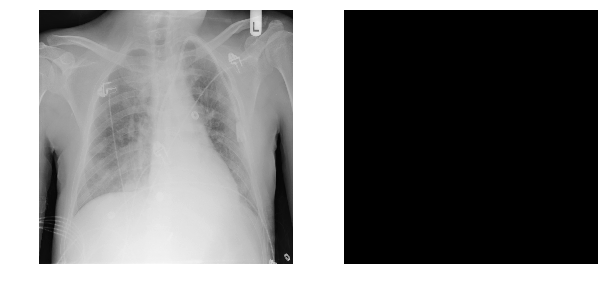

In [15]:
# Get a random image and annotation
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=raw_annotations)
random_patient_index = np.random.randint(low=0, high=NUM_TOTAL_TRAIN_IMGS)
image, annotation = get_image_and_annotation(random_patient_index, image_annotations)


# Show annotation
print(len(annotation))
# out = convert_annotation_to_ouput_shape(annotation)
mask, ids = convert_annotation_to_mask(annotation)

# Print patient's raw image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

# Print masked image
plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

## Split the data into training and validation datasets 
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**
 
 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [17]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# number_of_images_to_use = NUM_TOTAL_TRAIN_IMGS # To use all of them
number_of_images_to_use = 2 # To use some of them
#image_fps_list = list(image_fps[:number_of_images_to_use]) 
#####################################################################
image_fps_list = list(image_fps) 
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]
image_annotations_train = {k:v for k,v in image_annotations.items() if k in image_fps_train}
image_annotations_val = {k:v for k,v in image_annotations.items() if k in image_fps_val}

print(len(image_fps_train))
print(len(image_annotations_train))

23115
23115


# YOLO Starts here

In [0]:
# TODO somehow need to download the pretrained YOLO weights
# idk which one is right
#!wget https://pjreddie.com/media/files/yolo.weights 
#!wget https://pjreddie.com/media/files/yolov2.weights

In [0]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K

In [0]:
LABELS = ['PN'] # for pneumonia

# TODO idk what all this stuff means or does
# IMAGE_H, IMAGE_W = 416, 416
# GRID_H,  GRID_W  = 13 , 13
# BOX              = 1 # this is the number of anchors, I am just setting it to 1 for rn 
# CLASS            = len(LABELS)
# CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
# OBJ_THRESHOLD    = 0.3#0.5
# NMS_THRESHOLD    = 0.3#0.45
# ANCHORS          = [1.]

# NO_OBJECT_SCALE  = 1.0
# OBJECT_SCALE     = 5.0
# COORD_SCALE      = 1.0
# CLASS_SCALE      = 1.0

# BATCH_SIZE       = 16
# WARM_UP_BATCHES  = 0
# TRUE_BOX_BUFFER  = 50

config = dict(
    IMAGE_H = 416, 
    IMAGE_W = 416,
    GRID_H = 13,
    GRID_W = 13,
    BOX = 5,
    CLASS = len(LABELS),
    CLASS_WEIGHTS = np.ones(len(LABELS), dtype='float32'),
    OBJ_THRESHOLD = 0.3,#0.5
    NMS_THRESHOLD = 0.3,#0.45
    ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
    NO_OBJECT_SCALE = 1.0,
    OBJECT_SCALE = 5.0,
    COORD_SCALE = 1.0,
    CLASS_SCALE = 1.0,
    BATCH_SIZE = 2,
    WARM_UP_BATCHES = 0,
    TRUE_BOX_BUFFER = 50,
    ORIG_SIZE = 1024
)

train_generator = BatchGenerator(config,image_fps_train,image_annotations_train)
test_generator = BatchGenerator(config, image_fps_val, image_annotations_val)

### Construct the Network

In [0]:
# We still refer to these a lot of places, so I'm gonna put them back here for now.
# We need to clean up a lot though haha
IMAGE_H = 416
IMAGE_W = 416
GRID_H = 13
GRID_W = 13
BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(len(LABELS), dtype='float32')
OBJ_THRESHOLD = 0.3#0.5
NMS_THRESHOLD = 0.3#0.45
ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE = 1.0
OBJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0
BATCH_SIZE = 2
WARM_UP_BATCHES = 0
TRUE_BOX_BUFFER = 50
ORIG_SIZE = 1024

In [0]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
#output = Lambda(lambda args: args[0])([output, true_boxes])

output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [0]:
#model.summary()

### Custom Loss Function

From Paper:



![alt text](https://i.stack.imgur.com/bQAdd.jpg)

In [0]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h how it was before
    #pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.exp(y_pred[..., 2:4])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    #true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
    #                      lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
    #                               true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
    #                               tf.ones_like(coord_mask)],
    #                      lambda: [true_box_xy, 
    #                               true_box_wh,
    #                               coord_mask])
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

# Training

##Train model

### Why does this take forever???
- i dont think its only using the one image

- I think I effed something up lol. It used to work. but now I don't know what I changed that broke it.

In [0]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

model.compile(loss=custom_loss, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10000,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint])